In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# ToDos

# ff_HML stationary?

# need to force normal distribution?

# test features for heteroskedasticity against time?

# resolve multicolinerarity -> orthogonolisation
#     start off with highest correlation variables
    
# Regression
#     select variables

In [5]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
df_all.sort_values("date", inplace=True)
data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

('nan format unknonw',)
Unknown columns found
['date']


In [6]:
# select relevant data
drop_cols = data_dict["data_cols"]["goog_sent"]
df_w = df_all.drop(drop_cols, axis=1).copy()
df_w = cut_to_weekly_data(df_w).reset_index(drop=True)

df_w = shift_var_relative_to_df(df_w, shift_var="sp_close", new_var_name=["sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_close_lag4"], no_lags=[-1, -2, -3, -4])

In [8]:
df_w["sp_agg1"] = df_w.sp_close_lag2 + df_w.sp_close_lag3 + df_w.sp_close_lag4
df_w["sp_true_vals"] = df_w["sp_close"]

In [10]:
# edit data_dict
data_dict.update(predicted="sp_close_lag1")
data_dict.update(sp_true_vals="sp_true_vals")
data_dict.update(sp_cols=["sp_close", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_close_lag4", "sp_agg1"])


relevant_cols=[
    'fears35',
    'vixo',
    'naaim_ind',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    'termspread',
    'pc_ratio',
    'aaii_Bullish',
    # 'goog_sent'
] 
relevant_cols = relevant_cols + data_dict["sp_cols"]

data_dict.update(relevant_cols=relevant_cols)
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [11]:
# log transform
trans = DataTransformation(df_w,
                           data_dict)
trans.df_transform(data_dict["relevant_cols"] + data_dict["sp_cols"], transformation="log_return")

df_w = trans.df
data_dict = trans.dict_
df_w.dropna(inplace=True)

In [12]:
df_w["sp_agg2"] = df_w.sp_close_lag2 * df_w.sp_close_lag3 * df_w.sp_close_lag4

data_dict.update(relevant_cols=data_dict["relevant_cols"] + ["sp_agg2"])
data_dict.update(sp_cols=data_dict["sp_cols"] + ["sp_agg2"])

In [13]:
# test normality & stationarity
stest = StatsTest(plot=False)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
data_dict.update(normality=normality)

stationarity

{'fears35': True,
 'vixo': True,
 'naaim_ind': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': False,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'pc_ratio': True,
 'aaii_Bullish': True,
 'sp_close': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True,
 'sp_close_lag4': True,
 'sp_agg1': True,
 'sp_agg2': True}

# correlation

In [16]:
# select model features
cols = [
    'vixo',
     'naaim_ind',
     'ff_M_RF',
     # 'ff_SMB',
     'ff_RMW',
     # 'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     'aaii_Bullish',
    # 'ff_HML',
    'sp_close_lag2',
    # 'sp_agg1',
    'sp_agg2',
    # 'goog_sent',
    'sp_close_lag3',
    'fears35'
]

In [17]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

In [18]:
data_dict["lag_correl"] = lag_correl(df_w,
                                     cols,
                                     col_predicted="sp_close_lag1",
                                     show_fig=False
                                     )
# data_dict["lag_correl"]

# Multicolinerarity

,VIF,corr_sp_close_lag1
sp_close_lag2,1734.070286,-0.597172
sp_agg2,2552.606813,-0.539021
ff_M_RF,22.805091,-0.448206
aaii_Bullish,52.844270,-0.254292
naaim_ind,9.075265,-0.137420
sp_close_lag3,795.124554,0.123015
fears35,32.890354,0.217612
ff_RMW,40.349898,0.238361
vixo,109.673788,0.435338


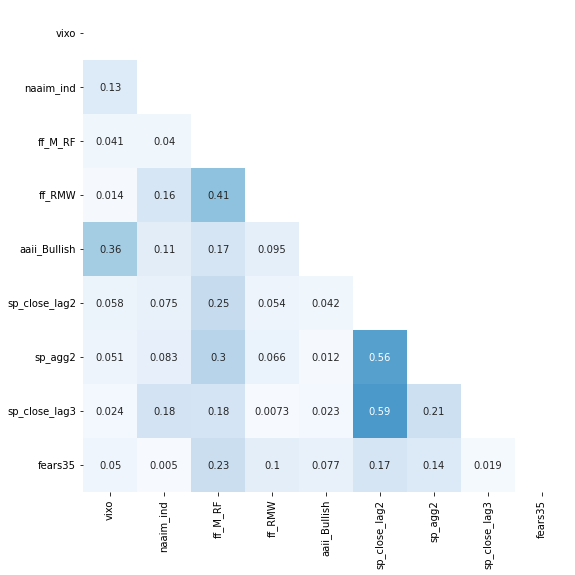

In [19]:
corr_heatmap(df_ws, 
             cols,
             size_factor=.9,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# Orthogonalise

In [20]:
df_train = df_ws.copy()

In [23]:
df_train = orthogonalise_vars(df_train,
                              X="sp_close_lag2",
                              y="sp_agg2",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="sp_close_lag2",
                              y="sp_close_lag3",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="sp_close_lag2",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="aaii_Bullish",
                              show_fig=False)

# df_train = orthogonalise_vars(df_train,
#                               X="vixo",
#                               y="pc_ratio",
#                               show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="ff_M_RF",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="ff_RMW",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="naaim_ind",
                              show_fig=False)

df_train = orthogonalise_vars(df_train,
                              X="vixo",
                              y="fears35",
                              show_fig=False)

# df_train = orthogonalise_vars(df_train,
#                               X="vixo",
#                               y="ff_CMA",
#                               show_fig=False)

# df_train = orthogonalise_vars(df_train,
#                               X="vixo",
#                               y="ff_HML",
#                               show_fig=False)

# df_train = orthogonalise_vars(df_train,
#                               X="vixo",
#                               y="ff_SMB",
#                               show_fig=False)

,VIF,corr_sp_close_lag1
sp_close_lag2,1.112257,-0.572741
ff_M_RF,1.429353,-0.430807
sp_close_lag3,1.099810,-0.289256
sp_agg2,1.096394,-0.246008
aaii_Bullish,1.049462,-0.106064
naaim_ind,1.079530,-0.081683
fears35,1.087215,0.196191
ff_RMW,1.243704,0.232325
vixo,1.000006,0.435338


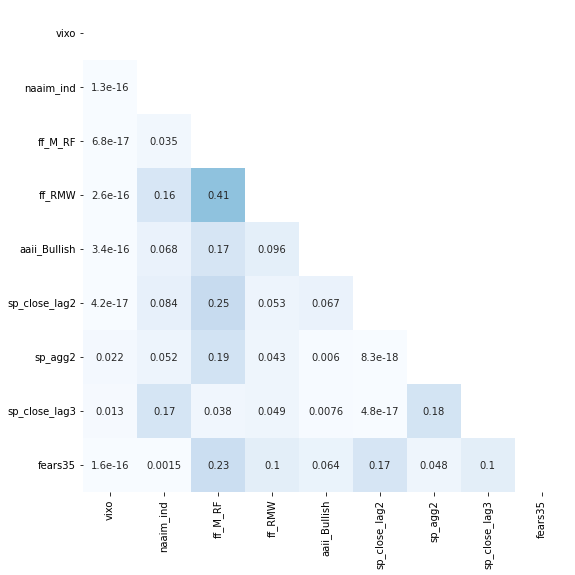

In [24]:
corr_heatmap(df_train, cols, size_factor=.9, show_fig=True)
get_variance_inflation_factor(df_train, cols, col_pred=data_dict["predicted"])

# Regression

In [25]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False, test_size=.3)

In [26]:
model = sm.OLS(y_train, X_train, random_state=random_state).fit()

In [27]:
model.pvalues < 0.05

vixo              True
naaim_ind        False
ff_M_RF           True
ff_RMW           False
aaii_Bullish      True
sp_close_lag2     True
sp_agg2           True
sp_close_lag3     True
fears35          False
intercept         True
dtype: bool

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sp_close_lag1   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     49.62
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           6.17e-45
Time:                        22:50:56   Log-Likelihood:                 624.66
No. Observations:                 197   AIC:                            -1229.
Df Residuals:                     187   BIC:                            -1196.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo              0.1057      0.011      9.864      0.000       0.085       0.127
naaim_ind        -0.0021      0.003     -0.750      0.454      -0.008       0.003
ff_M_RF          -0.0232      0.004     -5.164      0.000      -0.032      -0.014
ff_RMW            0.0108      0.007      1.611      0.109      -0.002       0.024
aaii_Bullish     -0.0255      0.008     -3.308      0.001      -0.041      -0.010
sp_close_lag2    -0.5292      0.043    -12.433      0.000      -0.613      -0.445
sp_agg2          -0.3591      0.113     -3.167      0.002      -0.583      -0.135
sp_close_lag3    -0.3180      0.054     -5.919      0.000      -0.424      -0.212
fears35          -0.0007      0.006     -0.106      0.916      -0.013       0.012
intercept         0.6198      0.007     82.693      0.000       0.605       0.635
==============================================================================
Omnibus:                       35.768   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.152
Skew:                           0.579   Prob(JB):                     5.54e-34
Kurtosis:                       7.162   Cond. No.                         188.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

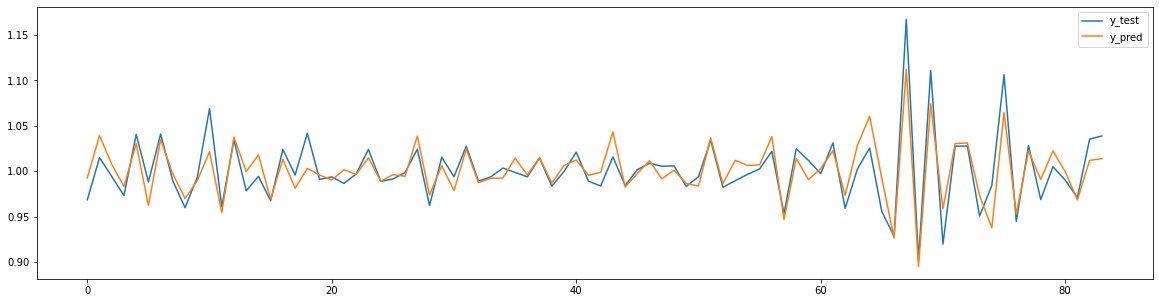

Validation Scores
mean squared error: 0.0003347
mean absolute error: 0.01351009
R2: 0.7667


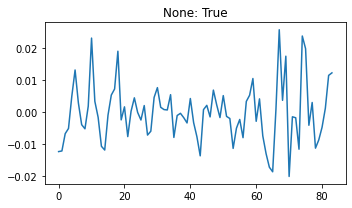

Stationarity Test Results
P-Values: 0.0010348883036164667
Test-stats: -4.0825496204946035
Time series is stationary: True


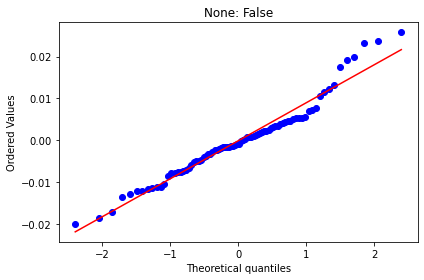

Normality Test Results
P-Values: 0.025126640095634076
Test-stats: 7.367653274590409
Series is normally distributed: False


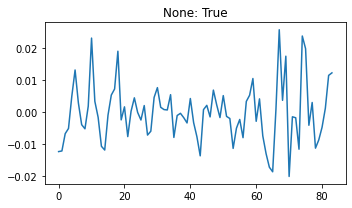

Test for Heteroskedasticity
Test p-value: 0.049698200051012296
Heteroskedasticity is present: True


In [29]:
mval = ModelValidation(X_test,
                y_test,
                model,
                data_dict)
mval.get_model_performance()
mval.analyse_resids(print_results=True)

# Plot results

In [161]:
df_r = df_w.copy()
# df_r.set_index("date", inplace=True)

In [162]:
df_r["sp_tot_pred_test"] = np.concatenate([np.array(list([np.nan] * len(model.predict()))),
                                            mval.pred_inv.values]) * df_r["sp_true_vals"]

df_r["sp_tot_pred_train"] = np.concatenate([arr_inv_log_returns(model.predict()),
                                            np.array(list([np.nan] * len(mval.pred_inv.values)))]) * df_r["sp_true_vals"]

df_r["sp_tot_pred_train"] = df_r["sp_tot_pred_train"].shift(1)
df_r["sp_tot_pred_test"] = df_r["sp_tot_pred_test"].shift(1)

Validation Scores Test Data
mean squared error: 2124.2505341819315
mean absolute error: 33.930697018342585
mean absolute error %: 1.9497593808556906


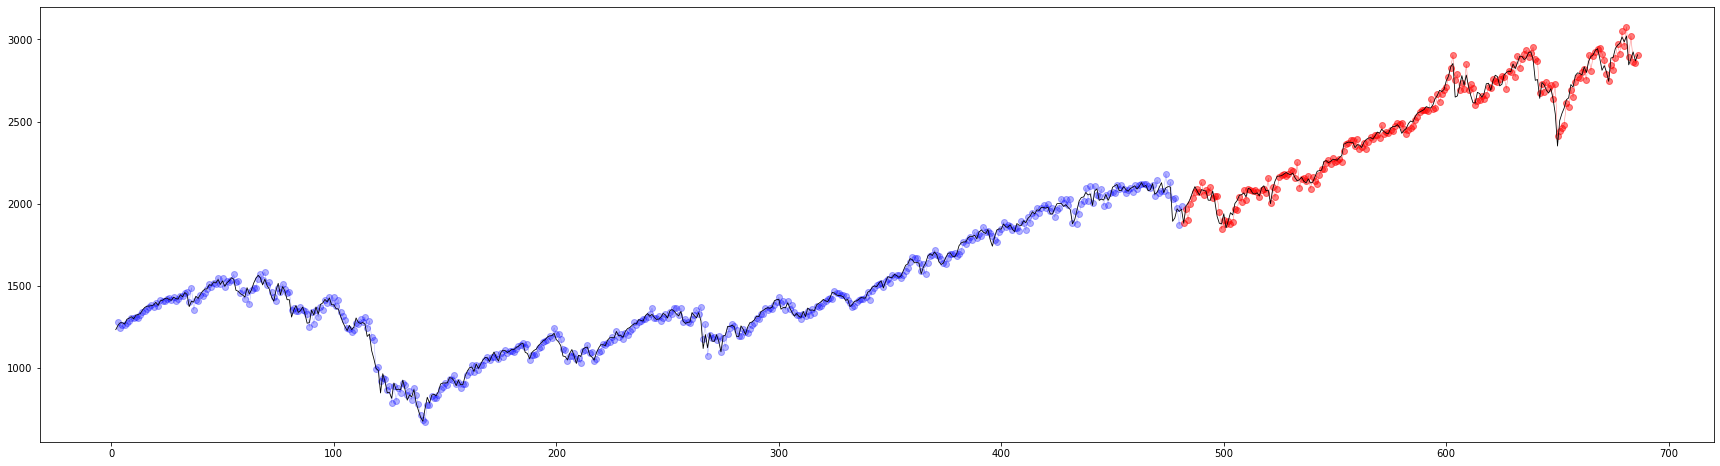

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(30, 8))
ax.plot(df_r["sp_tot_pred_train"], marker="o", lw=.5, alpha=.3, color="blue")
ax.plot(df_r["sp_tot_pred_test"], marker="o", lw=.5, alpha=.5, color="red")
ax.plot(df_r["sp_true_vals"], color="black", lw=.8)

# plt.xlim([400, 500])

print("Validation Scores Test Data")
print(f"mean squared error: {np.mean((df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']]) ** 2)}")
print(f"mean absolute error: {np.mean(abs(df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']]))}")
print(f"mean absolute error %: {(np.mean(abs(df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']])) / df_r[data_dict['sp_true_vals']].mean()) * 100}")

# Save model

In [168]:
save_model(df_train, model, mval, data_dict, name="four_features_vixo_splag_splagmul_pcr_ffMRF", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-08_four_features_vixo_splag_splagmul_pcr_ffMRF_model.pkl"? (y/n)


 y
